<a href="https://colab.research.google.com/github/nghiax4/Amazon-Sentiment-Analysis/blob/main/Amazon_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [ ]:
!pip install gdown

Dataset: Xiang Zhang's Google Drive dir: https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M: amazon_review_polarity_csv

In [ ]:
import gdown

file_url = 'https://drive.google.com/uc?id=0Bz8a_Dbh9QhbaW12WVVZS2drcnM'
file_dest = 'amazon_review_polarity_csv.tgz'
gdown.download(file_url, file_dest, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbaW12WVVZS2drcnM
From (redirected): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbaW12WVVZS2drcnM&confirm=t&uuid=0213ef30-583c-49be-b7ee-df1c8480b776
To: /content/amazon_review_polarity_csv.tgz
100%|██████████| 688M/688M [00:07<00:00, 94.9MB/s]


'amazon_review_polarity_csv.tgz'

In [ ]:
# Unzip files

!mkdir dataset
!tar -xzvf "amazon_review_polarity_csv.tgz" -C "dataset"

mkdir: cannot create directory ‘dataset’: File exists
amazon_review_polarity_csv/
amazon_review_polarity_csv/test.csv
amazon_review_polarity_csv/train.csv
amazon_review_polarity_csv/readme.txt


# Function to standardize text

In [ ]:
import pandas as pd
import re
from nltk import ngrams
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.model_selection import train_test_split
import os
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install contractions
import contractions

# Standardize text data
def standardize_data(row):
    # Make lowercase
    row = row.lower()

    # Expand contractions
    row = contractions.fix(row)

    # Remove all symbols like question marks, exclamation marks, etc.
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")

    row = row.strip()
    return row

# Load dataset

In [ ]:
TRAIN_CSV = 'dataset/amazon_review_polarity_csv/train.csv'
TEST_CSV = 'dataset/amazon_review_polarity_csv/test.csv'

In [ ]:
import random

train_samples = sum(1 for line in open(TRAIN_CSV))

print('Number of train samples: ', train_samples)

train_subset_samples = 10000

# Only load first 10000 samples for training
# skip = sorted(random.sample(range(1, train_samples + 1), train_samples - train_subset_samples))

columns = ['label', 'title', 'content']

Number of train samples:  3600000


In [ ]:
train_set = pd.read_csv(TRAIN_CSV, nrows = train_subset_samples, header = None, names = columns)
test_set = pd.read_csv(TEST_CSV, header = None, names = columns)

In [ ]:
train_set.drop(axis = 0, columns = 'title')

,label,content
0,2,This sound track was beautiful! It paints the ...
1,2,I'm reading a lot of reviews saying that this ...
2,2,This soundtrack is my favorite music of all ti...
3,2,I truly like this soundtrack and I enjoy video...
4,2,"If you've played the game, you know how divine..."
...,...,...
9995,2,"Though a scholarly biography, the book reveals..."
9996,2,"This biography of Arthur Aull, a small-town jo..."
9997,1,You'd be hard-pressed to tell a boring story a...
9998,1,The box looked used and it is obviously not ne...


In [ ]:
test_set.drop(axis = 0, columns = 'title')

,label,content
0,2,My lovely Pat has one of the GREAT voices of h...
1,2,Despite the fact that I have only played a sma...
2,1,I bought this charger in Jul 2003 and it worke...
3,2,Check out Maha Energy's website. Their Powerex...
4,2,Reviewed quite a bit of the combo players and ...
...,...,...
399995,1,We bought this Thomas for our son who is a hug...
399996,1,My son recieved this as a birthday gift 2 mont...
399997,1,"I bought this toy for my son who loves the ""Th..."
399998,2,This is a compilation of a wide range of Mitfo...


In [ ]:
# Convert label [1, 2] to [1, 0] (1 is negative, 0 is positive)

train_set['label'] = train_set['label'] - 1
train_set['label'] = 1 - train_set['label']

In [ ]:
train_set

,label,title,content
0,0,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,0,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,0,Amazing!,This soundtrack is my favorite music of all ti...
3,0,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,0,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
...,...,...,...
9995,0,A revelation of life in small town America in ...,"Though a scholarly biography, the book reveals..."
9996,0,Great biography of a very interesting journalist,"This biography of Arthur Aull, a small-town jo..."
9997,1,Interesting Subject; Poor Presentation,You'd be hard-pressed to tell a boring story a...
9998,1,Don't buy,The box looked used and it is obviously not ne...


In [ ]:
test_set['label'] = test_set['label'] - 1
test_set['label'] = 1 - test_set['label']

In [ ]:
train_set['content'] = train_set['content'].apply(standardize_data)
test_set['content'] = test_set['content'].apply(standardize_data)

# Data visualization

In [ ]:
import matplotlib.pyplot as plt
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


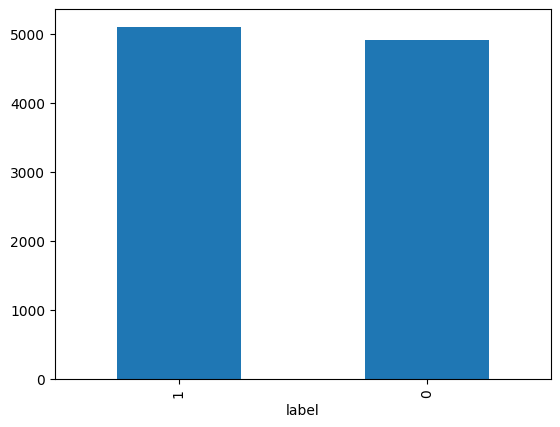

In [ ]:
# Label distribution

train_set['label'].value_counts().plot(kind='bar')
plt.savefig('plots/label_freq.png', dpi=300, bbox_inches='tight')

In [ ]:
# Word count distribution

train_set_with_wordcount = pd.DataFrame(train_set)
train_set_with_wordcount['wordcount'] = train_set_with_wordcount['content'].apply(len)
train_set_with_wordcount

,label,title,content,wordcount
0,0,Stuning even for the non-gamer,this sound track was beautiful it paints the ...,394
1,0,The best soundtrack ever to anything.,i am reading a lot of reviews saying that this...,475
2,0,Amazing!,this soundtrack is my favorite music of all ti...,755
3,0,Excellent Soundtrack,i truly like this soundtrack and i enjoy video...,722
4,0,"Remember, Pull Your Jaw Off The Floor After He...",if you have played the game you know how divi...,427
...,...,...,...,...
9995,0,A revelation of life in small town America in ...,though a scholarly biography the book reveals...,808
9996,0,Great biography of a very interesting journalist,this biography of arthur aull a small town jo...,810
9997,1,Interesting Subject; Poor Presentation,you would be hard pressed to tell a boring sto...,614
9998,1,Don't buy,the box looked used and it is obviously not ne...,124


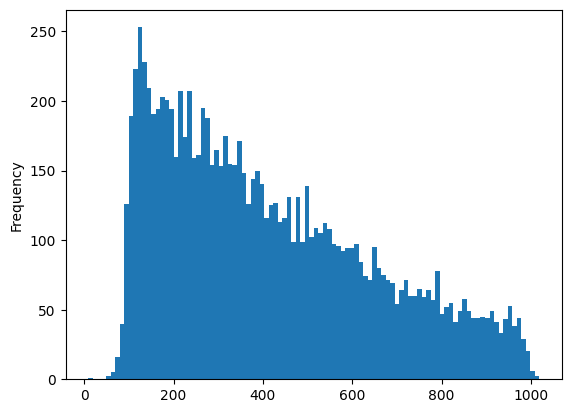

In [ ]:
train_set_with_wordcount['wordcount'].plot(kind='hist', bins=100)
plt.savefig('plots/wordcount_freq.png', dpi=300, bbox_inches='tight')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# based on https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
def get_top_n_kgrams(k = 1, n = 1, filter_stopwords = False):
    vec = []
    if filter_stopwords:
      vec = CountVectorizer(ngram_range=(k, k), stop_words = 'english').fit(train_set['content'])
    else:
      vec = CountVectorizer(ngram_range=(k, k)).fit(train_set['content'])

    bag_of_words = vec.transform(train_set['content'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
def plot_top_n_kgrams(k = 1, n = 1, filter_stopwords = False):
    kgrams = get_top_n_kgrams(k, n, filter_stopwords)
    df_tmp = pd.DataFrame(kgrams, columns = ['words', 'count'])
    df_tmp = df_tmp.groupby('words').sum()['count'].sort_values(ascending=False)
    df_tmp.plot(kind='bar')

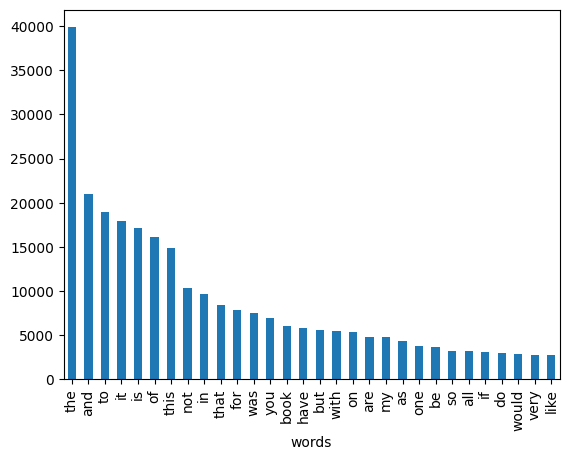

In [ ]:
plot_top_n_kgrams(1, 30)
plt.savefig('plots/top_unigrams_nofilter.png', dpi=300, bbox_inches='tight')

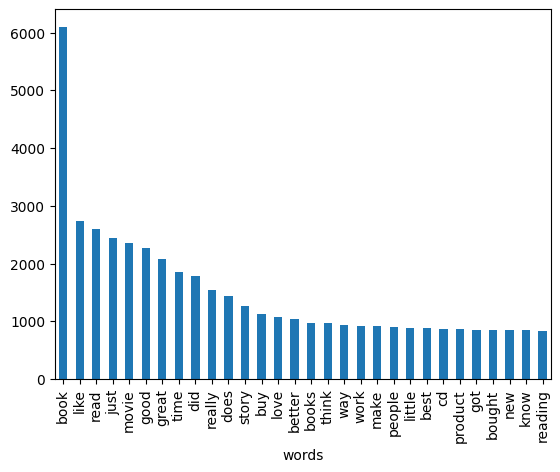

In [ ]:
plot_top_n_kgrams(1, 30, True)
plt.savefig('plots/top_unigrams_filter.png', dpi=300, bbox_inches='tight')

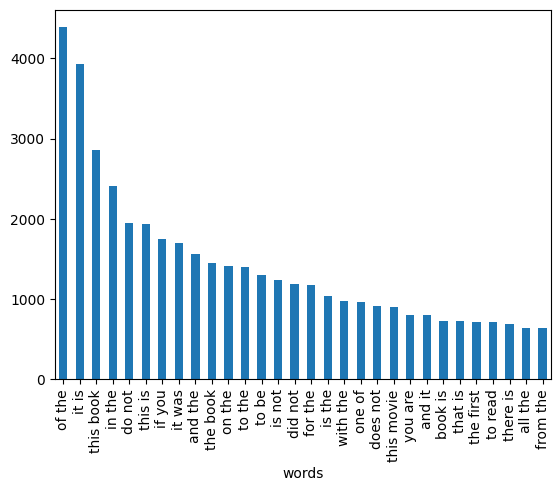

In [ ]:
plot_top_n_kgrams(2, 30)
plt.savefig('plots/top_bigrams_nofilter.png', dpi=300, bbox_inches='tight')

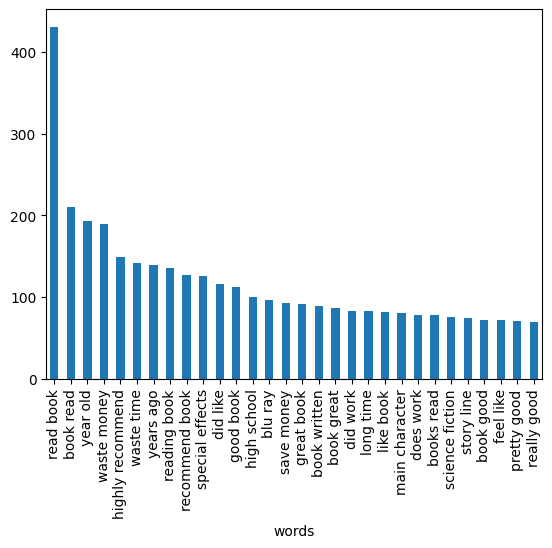

In [ ]:
plot_top_n_kgrams(2, 30, True)
plt.savefig('plots/top_bigrams_filter.png', dpi=300, bbox_inches='tight')

# Split up content and label

In [ ]:
X_train, y_train = train_set['content'], train_set['label']
print(X_train)
print(y_train)

0       this sound track was beautiful  it paints the ...
1       i am reading a lot of reviews saying that this...
2       this soundtrack is my favorite music of all ti...
3       i truly like this soundtrack and i enjoy video...
4       if you have played the game  you know how divi...
                              ...                        
9995    though a scholarly biography  the book reveals...
9996    this biography of arthur aull  a small town jo...
9997    you would be hard pressed to tell a boring sto...
9998    the box looked used and it is obviously not ne...
9999    the pen was shipped promptly  this is the clas...
Name: content, Length: 10000, dtype: object
0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: label, Length: 10000, dtype: int64


In [ ]:
X_test, y_test = test_set['content'], test_set['label']

# Embedding text data

In [ ]:
# Embedding
def embedding(X_train, X_test):
    emb = TfidfVectorizer(min_df=5, max_df=0.8, max_features=5000, sublinear_tf=True, stop_words = 'english')
    emb.fit(X_train)
    X_train = emb.transform(X_train)
    X_test = emb.transform(X_test)

    # Save pkl file
    joblib.dump(emb, 'tfidf.pkl')
    return X_train, X_test

In [ ]:
X_train, X_test = embedding(X_train, X_test)

# Train and save model

In [ ]:
model = svm.SVC(kernel='linear')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
model.score(X_test, y_test)

0.81545

In [ ]:
joblib.dump(model, 'saved_model.pkl')

['saved_model.pkl']

# Test with amazon reviews

In [ ]:
import joblib
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np

In [ ]:
emb = joblib.load('tfidf.pkl')

In [ ]:
# cookie stuff on my pc idk i dont think this should be public ppl can hack me with this
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "Cookie":'session-id=139-7792766-4917763; sp-cdn="L5Z9:VN"; ubid-main=132-7498913-0226016; lc-main=en_US; x-main=ST8wRlFkZ39w8QUoErqV54gy0MnpEyN5Bz3RN8c08XYTh8U59qt9ueINfFawfHSm; at-main=Atza|IwEBIKLIeE5-WvNXP-oICvb55AT_b7G9i1r0QhpLScE5_6HtjnEBIQnP-LrBUc2EHcnMaBXLMaFuaOQvUJId13P9j13s3W8_BHZ74HilzgHfWGN-_gJ8N7Vcmw3v-VHiO_A0LNDakKbYwhe4Q3dcvGk41MTk-bcxzo5a4to4sqSpHJjeig29-iKsmSOqz1lZAXCkXvLa0Gq3KD7TH4Tgk0reV1Xex4yNRiGI4rKTxQEUBfAmJ63sWLbsd0EwgKWVmIrcNqjthpjsmW4FVHMy2SFsCzo_naPHosnQ4Z6V32ejxVU0_A; sess-at-main="kW4e4WF1oy8c1IAXExL3+UaYzCDBtT4D8xpNcpo3cv8="; sst-main=Sst1|PQGl_G6fRccbjTuWeTc-Cce7CXInvkgCl8OnK59LWhGB6VtoDwpeW19LfNqE5JcUj5kB7OBv8nFTqVMfrO5N14KjfzzsXEIPBkLU7WIM366_OARBuY32HuLiK23Ojrxk4OSbHVpXel0ORtvLCI2ESj0Cke4zckPhysXu40hO26DC-8-CGzBFZp67mo9zugFbcENRGvEY08loIYK8E2uEsCE05qKVTvjNaTeOVRfUS_4bfQVsH0FgD8KhgBjyf9LDLd1U2XBn1t51A86VrLd-0B270HNnvkClIb5KJFKAOuNERqY; session-id-time=2082787201l; i18n-prefs=USD; session-token=3Ir/QhwRZWJ8WYy2lWcBrS/UZFXAg/8Bkq3EAIKwhsUHiB9QklCWO8FdS8FFxHodkDacWfC3QwsF6K3y7RCgkXzKToLYA2mPjlndus5e6v6oZOk/yhPRpfhjwIA97JIiiqZz1BXfffSRE2K+Md9YjA5brfveInhWOLRAme88rEYrCdAK9mpsOOUjYHOyMmL3nohultqMcBwFXqB67Ja+iSOpXqmiyji7btB2iVYpzp5xMeTIT7b4Wpka9Cv7Flrl9BpAdRFI13Lv7tFl0+Asqn9eHsG5fbzqZGUWP/Dj/KzmdRxR1I/RBKQk03SnA0bVbcgCO38OHIR+hkw3qQFL3aG+5ZJTKhe7YXUlzzV6cyqrRSxoeoLRthth3T6X2ien; csm-hit=tb:C3G3R0PWPNYD3P3WNSWW+b-C3G3R0PWPNYD3P3WNSWW|1711512147362&t:1711512147362&adb:adblk_yes'
}

In [ ]:
# Thanks le bao long
def get_amazon_reviews(product_id, max_page_number):
    reviews = []

    for i in range(1, max_page_number + 1):
        url = f"https://www.amazon.com/product-reviews/{product_id}?ie=UTF8&pageNumber={i}"

        response = requests.get(url, headers = headers)
        soup = BeautifulSoup(response.content, 'html.parser')

        review_texts = soup.select("#cm_cr-review_list .review-text-content > span")
        reviews += [review.get_text(strip = True) for review in review_texts]

    return reviews

In [ ]:
def analyze(result):
    bad = np.count_nonzero(result)
    good = len(result) - bad
    print("No of bad and neutral comments = ", bad)
    print("No of good comments = ", good)

    if good > bad:
        return "Good! You can buy it!"
    else:
        return "Bad! Please check it carefully!"

In [ ]:
product_id = 'B09G9FPHY6'

In [ ]:
amaz_reviews = get_amazon_reviews(product_id, 3)
print(len(amaz_reviews))
print(amaz_reviews[:min(len(amaz_reviews), 5)])

31
['Bought for granddaughter. She loves it. Just what she was wanting. Good price. Fast shipment. Well packaged. Easy set up. Great system', "I've been using the Apple iPad (9th Generation) for my kids' daily activities, and I have to say, it's been a reliable companion. The A13 Bionic chip ensures smooth performance, handling everything from homework assignments to entertainment with ease. The 10.2-inch Retina Display delivers crisp and clear visuals, making learning and entertainment enjoyable.The 64GB storage capacity provides ample space for apps, games, and educational content. The Wi-Fi connectivity allows for seamless internet access, and the Touch ID feature adds an extra layer of security.The 12MP front and 8MP back cameras capture decent photos and videos, perfect for documenting memories or attending virtual classes. Plus, the all-day battery life ensures the device lasts through long hours of use.Overall, the Apple iPad (9th Generation) offers reliable performance and qual

In [ ]:
# It has to be like this to work idk cant convert to Series right away

amaz_reviews = pd.DataFrame(amaz_reviews)
amaz_reviews = amaz_reviews[0]

In [ ]:
amaz_reviews = amaz_reviews.apply(standardize_data)
print(amaz_reviews)

0     bought for granddaughter  she loves it  just w...
1     i have been using the apple ipad (9th generati...
2     the apple ipad (9th generation) is a technolog...
3     i have learned to buy only apple products  the...
4     my ipad pro lasted me about 3 years  so had to...
5     i wanted to wait to write a review and i am gl...
6     this a great tablet for the price   it is fast...
7     works great  quality is prestige  performance ...
8     it is not just a purchase  it is an investment...
9     i purchased this as a replacement for my son s...
10    i had not received this yet but not a doubt in...
11    there is nothing to complain about the tracker...
12    first of all  the battery life is excellent   ...
13    i already have a 9th generation ipad that my k...
14    apple ipad 9th gen   moved up from a 5th gen i...
15    i needed to buy a new ipad as my ipad mini 2 h...
16    so far i like everything about my ipad   i hav...
17    drawing feels natural  she loves using the

In [ ]:
amaz_reviews_embed = emb.transform(amaz_reviews)
print(amaz_reviews_embed)

  (0, 4828)	0.37971273095412844
  (0, 3944)	0.25779690462071597
  (0, 3385)	0.25283240977035043
  (0, 3134)	0.4140467082796422
  (0, 2699)	0.3127906530342776
  (0, 2454)	0.15367153813326967
  (0, 1995)	0.16310693045835042
  (0, 1987)	0.4379193285430498
  (0, 1963)	0.1582322437093429
  (0, 1674)	0.2898034197714095
  (0, 1421)	0.24810751887642887
  (0, 542)	0.20878013443653148
  (1, 4796)	0.13149232226323057
  (1, 4770)	0.11225719966743397
  (1, 4732)	0.08267642963030535
  (1, 4725)	0.1129238104116413
  (1, 4564)	0.11129607484887262
  (1, 4252)	0.13247077300989238
  (1, 4145)	0.10275149178923138
  (1, 4090)	0.11847840932484906
  (1, 3832)	0.06801534825441634
  (1, 3634)	0.22604389346224502
  (1, 3494)	0.07382125011149554
  (1, 3454)	0.1103834311947932
  (1, 3289)	0.09987863322218579
  :	:
  (29, 1995)	0.09205691991723379
  (29, 1912)	0.22977242589589908
  (29, 1277)	0.14234127544037253
  (29, 1251)	0.19409630928366842
  (29, 1229)	0.3615621880370924
  (29, 1125)	0.16962247718041693
  (29

In [ ]:
model = joblib.load("saved_model.pkl")
result = model.predict(amaz_reviews_embed)

In [ ]:
print(result)
print(analyze(result))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
No of bad and neutral comments =  4
No of good comments =  27
Good! You can buy it!
